# Adaptive Signal POD using Kriging

In [1]:
# import relevant module
import openturns as ot
import otpod
# enable display figure in notebook
%matplotlib inline
import numpy as np

## Generate data

In [2]:
inputSample = ot.NumericalSample(
    [[4.59626812e+00, 7.46143339e-02, 1.02231538e+00, 8.60042277e+01],
    [4.14315790e+00, 4.20801346e-02, 1.05874908e+00, 2.65757364e+01],
    [4.76735111e+00, 3.72414824e-02, 1.05730385e+00, 5.76058433e+01],
    [4.82811977e+00, 2.49997658e-02, 1.06954641e+00, 2.54461380e+01],
    [4.48961094e+00, 3.74562922e-02, 1.04943946e+00, 6.19483646e+00],
    [5.05605334e+00, 4.87599783e-02, 1.06520409e+00, 3.39024904e+00],
    [5.69679328e+00, 7.74915877e-02, 1.04099514e+00, 6.50990466e+01],
    [5.10193991e+00, 4.35520544e-02, 1.02502536e+00, 5.51492592e+01],
    [4.04791970e+00, 2.38565932e-02, 1.01906882e+00, 2.07875350e+01],
    [4.66238956e+00, 5.49901237e-02, 1.02427200e+00, 1.45661275e+01],
    [4.86634219e+00, 6.04693570e-02, 1.08199374e+00, 1.05104730e+00],
    [4.13519347e+00, 4.45225831e-02, 1.01900124e+00, 5.10117047e+01],
    [4.92541940e+00, 7.87692335e-02, 9.91868726e-01, 8.32302238e+01],
    [4.70722074e+00, 6.51799251e-02, 1.10608515e+00, 3.30181002e+01],
    [4.29040932e+00, 1.75426222e-02, 9.75678838e-01, 2.28186756e+01],
    [4.89291400e+00, 2.34997929e-02, 1.07669835e+00, 5.38926138e+01],
    [4.44653744e+00, 7.63175936e-02, 1.06979154e+00, 5.19109415e+01],
    [3.99977452e+00, 5.80430585e-02, 1.01850716e+00, 7.61988190e+01],
    [3.95491570e+00, 1.09302814e-02, 1.03687664e+00, 6.09981789e+01],
    [5.16424368e+00, 2.69026464e-02, 1.06673711e+00, 2.88708887e+01],
    [5.30491620e+00, 4.53802273e-02, 1.06254792e+00, 3.03856837e+01],
    [4.92809155e+00, 1.20616369e-02, 1.00700410e+00, 7.02512744e+00],
    [4.68373805e+00, 6.26028935e-02, 1.05152117e+00, 4.81271603e+01],
    [5.32381954e+00, 4.33013582e-02, 9.90522007e-01, 6.56015973e+01],
    [4.35455857e+00, 1.23814619e-02, 1.01810539e+00, 1.10769534e+01]])

signals = ot.NumericalSample(
    [[ 37.305445], [ 35.466919], [ 43.187991], [ 45.305165], [ 40.121222], [ 44.609524],
     [ 45.14552 ], [ 44.80595 ], [ 35.414039], [ 39.851778], [ 42.046049], [ 34.73469 ],
     [ 39.339349], [ 40.384559], [ 38.718623], [ 46.189709], [ 36.155737], [ 31.768369],
     [ 35.384313], [ 47.914584], [ 46.758537], [ 46.564428], [ 39.698493], [ 45.636588],
     [ 40.643948]])

# Select point as initial DOE
inputDOE = inputSample[:7]
outputDOE = signals[:7]

# simulate the true physical model
basis = ot.ConstantBasisFactory(4).build()
covModel = ot.SquaredExponential(4)
krigingModel = ot.KrigingAlgorithm(inputSample, signals, basis, covModel)
TNC = ot.TNC()
TNC.setBoundConstraints(ot.Interval([0.001], [100]))
krigingModel.setOptimizer(TNC)
krigingModel.run()
physicalModel = krigingModel.getResult().getMetaModel()

## Create the Adaptive Signal POD with Kriging model

This method aims at improve the quality of the Kriging model where the 
accuracy of the computed POD is the lowest.

As this method is time consuming, it is more efficient to reduce the
area of the defect size only in the most interesting part. To do that,
an initial POD study can be run.

#### Run an initial POD study with the kriging technique

In [3]:
detection = 38.
initialPOD = otpod.KrigingPOD(inputDOE, outputDOE, detection)
initialPOD.run()

Start optimizing covariance model parameters...
Kriging optimizer completed
Q2 : 0.9425
Computing POD per defect: [==================================================] 100.00% Done


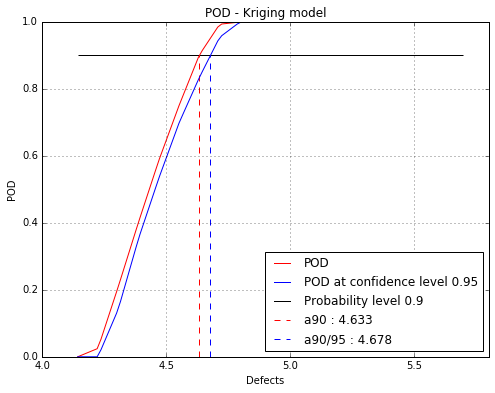

In [5]:
fig, ax = initialPOD.drawPOD(0.9, 0.95)
fig.show()

Based on this study, the interesting part for the defects ranges from 4.2 to 4.8. The adaptive signal algorithm will be then reduced to this area.
#### Run the adaptive algorithm

In [7]:
detection = 38
# set the number of iterations
nIteration = 2


adaptivePOD = otpod.AdaptiveSignalPOD(inputDOE, outputDOE, physicalModel, nIteration, detection)
# we set the range for the defect sizes between 4.2 and 4.8
adaptivePOD.setDefectSizes([4.2, 4.35, 4.5, 4.6, 4.7, 4.8])
# we can change the same parameters as in the Kriging POD method
# We can change also the number candidate points for which the critertion is computed
adaptivePOD.setCandidateSize(200)
# we can change the sample size of the Monte Carlo simulation
adaptivePOD.setSamplingSize(500) # default is 5000
# we can also change the size of the simulation to compute the confidence interval
adaptivePOD.setSimulationSize(50) # default is 1000
adaptivePOD.setGraphActive(False)
%time adaptivePOD.run()


Iteration : 1/2
Optimization of the covariance model parameters...
Q2 : 0.9425
Computing criterion: [==================================================] 100.00% Done
Criterion value : 0.0193
Added point : [4.34967,0.0430427,1.0646,50.4348]

Iteration : 2/2
Q2 : 0.9844
Computing criterion: [==================================================] 100.00% Done
Criterion value : 0.0176
Added point : [4.54894,0.0769159,1.06655,44.5168]

CPU times: user 7min 31s, sys: 1min 14s, total: 8min 45s
Wall time: 3min 14s


In [8]:
kr = adaptivePOD.getKrigingResult()
inputfinal = adaptivePOD.getInputDOE()
outputfinal = adaptivePOD.getOutputDOE()
finalPOD = otpod.KrigingPOD(inputfinal, outputfinal, detection)
finalPOD.setKrigingResult(kr)
finalPOD.run()

Q2 : 0.9896
Computing POD per defect: [==================================================] 100.00% Done


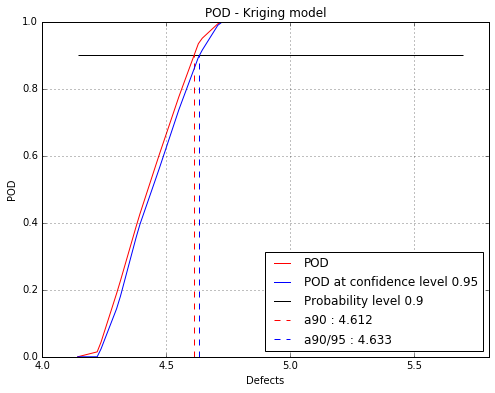

In [9]:
fig, ax = finalPOD.drawPOD(0.9, 0.95)
fig.show()

## Compute the Q2
Enable to check the quality of the model.

In [10]:
print 'Q2 : {:0.4f}'.format(adaptivePOD.getQ2())

Q2 : 0.9844


### Draw the validation graph
The predictions are the one computed by leave one out.

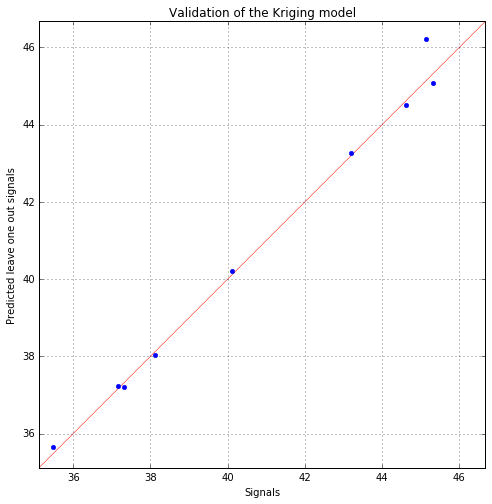

In [11]:
fig, ax = adaptivePOD.drawValidationGraph()
fig.show()

## Compute detection size

In [12]:
# Detection size at probability level 0.9 and confidence level 0.95
print 'Initial POD : ', initialPOD.computeDetectionSize(0.9, 0.95)
print 'After 5 added points : ', adaptivePOD.computeDetectionSize(0.9, 0.95)

Initial POD :  [a90 : 4.63276, a90/95 : 4.67841]
After 5 added points : 

AttributeError: 'AdaptiveSignalPOD' object has no attribute '_PODmodel'

## Show POD graphs
### Mean POD and POD at confidence level with the detection size for a given probability level

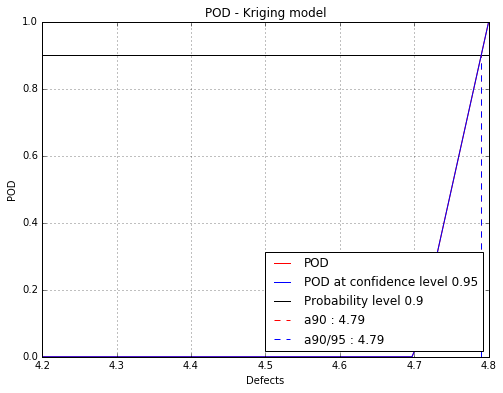

In [9]:
fig, ax = adaptivePOD.drawPOD(probabilityLevel=0.9, confidenceLevel=0.95,
                      name='figure/PODKriging.png')
# The figure is saved in PODPolyChaos.png
fig.show()